# Data processing and Training for Object detection and segmentation
Download the MIT indoor scenes database and change the filepath's to match your file structure.


# Imports

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from google.colab import drive
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn

In [ ]:
import torch.multiprocessing as mp


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("cuda")


cuda


## Data cleaning

In [ ]:
import os
import shutil

In [ ]:
pathToImagesFolder = "/content/gdrive/MyDrive/3rd Year/APS360/Project/MIT_indoor_scenes/archive/indoorCVPR_09/Images"
pathToAnnotationsFolder = "/content/gdrive/MyDrive/3rd Year/APS360/Project/MIT_indoor_scenes/archive/indoorCVPR_09annotations/Annotations"

In [ ]:
imageSubfolders = os.listdir(pathToImagesFolder)
annotationsSubfolders = os.listdir(pathToAnnotationsFolder)

In [ ]:
pathToCleanImagesFolder = "/content/gdrive/MyDrive/3rd Year/APS360/Project/MIT_indoor_scenes/cleanImages"
pathToCleanAnnotationsFolder = "/content/gdrive/MyDrive/3rd Year/APS360/Project/MIT_indoor_scenes/cleanAnnotations"

In [ ]:
# run this ONLY ONCE.
only put images with an annotation into the respective clean folders
for subfolder in imageSubfolders:
  annotationsSubfolderPath = os.path.join(pathToAnnotationsFolder, subfolder)
  annotationsSubfolder = os.listdir(annotationsSubfolderPath)

  imageSubfolderPath = os.path.join(pathToImagesFolder, subfolder)
  imageSubfolder = os.listdir(imageSubfolderPath)
  print(subfolder)
  count = 0
  for file1 in imageSubfolder:
    file1NoExtension = file1[:-3]
    file1XML = file1NoExtension + "xml"
    fullAnnotationPath = os.path.join(annotationsSubfolderPath, file1XML)
    if os.path.isfile(fullAnnotationPath):
      # copy image to clean folder
      pathToSource = os.path.join(imageSubfolderPath, file1)
      shutil.copy(pathToSource, pathToCleanImagesFolder)

      # copy annotation to clean folder
      pathToSource = os.path.join(annotationsSubfolderPath, file1XML)
      shutil.copy(pathToSource, pathToCleanAnnotationsFolder)
      count += 1
  print(count)


In [ ]:
!pip install xmltodict

In [ ]:
import xmltodict

In [ ]:
# no need to rerun
cleanAnnotationsFolder = os.listdir(pathToCleanAnnotationsFolder)
all_objects = {}
filesToDelete = []
for xmlFile in cleanAnnotationsFolder:
  filePath = os.path.join(pathToCleanAnnotationsFolder, str(xmlFile))
  with open(filePath) as file:
    xmlData = file.read()

  try:
    data1 = xmltodict.parse(xmlData)
  except:
    filesToDelete.append(xmlFile)
    continue;
  try:
    for item in data1["annotation"]["object"]:
      if not item["name"] in all_objects:
        all_objects[item["name"]] = 1
      else:
        all_objects[item["name"]] += 1
  except:
    filesToDelete.append(xmlFile)



print(len(all_objects))
print(filesToDelete)

2970
[]


In [ ]:
# no need to rerun
sorted_dict = sorted(all_objects.items(), key=lambda item: item[1], reverse=True)

top_500_keys = [k for k, v in sorted_dict[:500]]

for key in top_500_keys:
  print(key)

In [ ]:
listOfDesiredClasses = ["chair", "wall", "lamp", "door", "table", "cabinet", "cupboard", "shelves", "desk",
                        "sink", "column", "bed", "counter", "glass", "shelf", "armchair", "seats", "sofa", "stove",
                        "bookcase", "stool", "bar", "worktop", "drawer", "statue", "staircase", "counter top",
                        "railing", "washbasin", "handrail", "sculpture", "fireplace", "ottoman", "bathtub",
                        "dresser", "night table", "wardrobe", "furniture", "washing machine", "couch", "bookshelf",
                        "curtains", "fridge", "coffee table", "exit sign", "pillar", "file cabinet",
                        "night stand table", "rack", "pantry"]

count = 0
for element in listOfDesiredClasses:
  count += 1
print(count)

50


In [ ]:
#delete bad annotation files
# no need to rerun

for xmlfile in filesToDelete:
  jpgfile = xmlfile[:-3] + "jpg"
  jpgFilePath = os.path.join(pathToCleanImagesFolder, jpgfile)
  xmlFilePath = os.path.join(pathToCleanAnnotationsFolder, xmlfile)
  os.remove(jpgFilePath)
  os.remove(xmlFilePath)
  print("Removed: ")
  print("\t", jpgFilePath)
  print("\t", xmlFilePath)

In [ ]:
# no need to rerun
# find files that dont have relevant objects
count = 0
moreFilesToDelete = []
cleanAnnotationsFolder = os.listdir(pathToCleanAnnotationsFolder)

for xmlfile in cleanAnnotationsFolder:
  jpgfile = xmlfile[:-3] + "jpg"
  jpgFilePath = os.path.join(pathToCleanImagesFolder, jpgfile)
  xmlFilePath = os.path.join(pathToCleanAnnotationsFolder, xmlfile)
  img = Image.open(jpgFilePath)

  with open(xmlFilePath) as file:
    xmlData = file.read()

  data1 = xmltodict.parse(xmlData)

  objectList = []

  for thing in data1["annotation"]["object"]:
    if thing["name"] in listOfDesiredClasses:
      objectList.append(thing["name"])

  if len(objectList) == 0:
    moreFilesToDelete.append(xmlfile)

In [ ]:
# no need to rerun
# delete bad annotation files again

for xmlfile in moreFilesToDelete:
  jpgfile = xmlfile[:-3] + "jpg"
  jpgFilePath = os.path.join(pathToCleanImagesFolder, jpgfile)
  xmlFilePath = os.path.join(pathToCleanAnnotationsFolder, xmlfile)
  os.remove(jpgFilePath)
  os.remove(xmlFilePath)
  print("Removed: ")
  print("\t", jpgFilePath)
  print("\t", xmlFilePath)

In [ ]:
# no need to rerun
cleanImagesFolder = os.listdir(pathToCleanImagesFolder)
count = 0
averageWidth = 0
averageHeight = 0
for image in cleanImagesFolder:
  jpgFilePath = os.path.join(pathToCleanImagesFolder, image)
  with Image.open(jpgFilePath) as img:
    width, height = img.size
    averageWidth += width
    averageHeight += height
    count += 1

print(averageWidth/count)
print(averageHeight/count)

print(len(cleanImagesFolder))


2517


## Create custom dataset

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageDraw

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
from torchvision.ops.boxes import masks_to_boxes


In [ ]:
# FINISHED FINAL CUSTOM DATASET
class imageAndAnnotationsCustomDataset2(Dataset):
  def __init__(self):
    self.newImageWidth = 500
    self.newImageHeight = 500
    self.fileList = os.listdir(pathToCleanImagesFolder)


  def setAllInfo(self, fileName):
    try:
      self.imageArray = self.convertToArray(fileName)
      self.originalImageWidth = self.imageArray.shape[1]
      self.originalImageHeight = self.imageArray.shape[0]

      self.objectList, self.polylist = self.objectAndPolyList(fileName)
      self.imageTensor = self.convertToTensor(fileName)

      self.masks = self.AllPolyToMask(self.polylist)
      self.boundingBoxes = self.getAllBoudingBoxes(self.masks)
      del self.imageArray
    except:
      print("exception")

  def convertToArray(self, fileName):
    jpgFilePath = os.path.join(pathToCleanImagesFolder, fileName)
    with Image.open(jpgFilePath) as img:
    # plt.imshow(img)
      return np.array(img)

  def convertToTensor(self, fileName):
    jpgFilePath = os.path.join(pathToCleanImagesFolder, fileName)
    with Image.open(jpgFilePath) as img:
      # plt.imshow(img)
      transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     transforms.Resize((self.newImageHeight,self.newImageHeight))]) # normalize pixel values, resize, and tranform to tensor
      imgTransformed = transform(img)
      return imgTransformed

  def objectAndPolyList(self, fileName):
    xmlFilePath = os.path.join(pathToCleanAnnotationsFolder, fileName[:-3] + "xml")
    with open(xmlFilePath) as file:
      xmlData = file.read()

    data1 = xmltodict.parse(xmlData)

    objectList = []
    polyList = []

    for thing in data1["annotation"]["object"]:
      if thing["name"] in listOfDesiredClasses:
        pointArray = []
        for point in thing["polygon"]["pt"]:
          pointArray.append((int(point["x"]), int(point["y"])))

        objectList.append(listOfDesiredClasses.index(thing["name"]))
        polyList.append(pointArray)

    return objectList, polyList

  def polyToMask(self, polygon):
    image = Image.new('L', (self.originalImageWidth, self.originalImageHeight), "black")
    draw = ImageDraw.Draw(image)
    draw.polygon(polygon, outline="white", fill="white")
    mask = np.array(image)
    maskReduced = mask / 255
    transform1 = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((self.newImageWidth,self.newImageHeight), InterpolationMode.NEAREST_EXACT)])
    maskTensor = transform1(maskReduced)
    return maskTensor

  def AllPolyToMask(self, polyList):
    newList = []
    for polygon in polyList:
      newList.append(self.polyToMask(polygon))
    return newList

  def getAllBoudingBoxes(self, masks):
    newList = []
    for mask in masks:

      newList.append(masks_to_boxes(mask).squeeze(0))
    return newList

  def __len__(self):
    imageList = os.listdir(pathToCleanImagesFolder)
    numSamples = len(imageList)
    return numSamples

  def __getitem__(self, idx):
    fileName = self.fileList[idx]
    self.setAllInfo(fileName)
    print(idx)

    imageTensor = self.imageTensor.to(device)

    labels = torch.tensor(self.objectList).clone().to(device)
    masks = torch.stack(self.masks).clone().to(device)
    boxes = torch.stack(self.boundingBoxes).clone().to(device)

    targets = {'boxes': boxes, 'labels': labels, 'masks': masks}

    # data = {'images': imageTensor, 'targets': targets}

    return imageTensor, targets

def customColate(batch):
  images = [item[0] for item in batch]
  targets = [item[1] for item in batch]
  return {'images': images, 'targets': targets}

## Create DataLoader

In [ ]:
from torch.utils.data import random_split

In [ ]:
def get_data_loader(batch_size = 16):
  np.random.seed(1)

  newDataset = imageAndAnnotationsCustomDataset2()

  # not enough memory for a larger dataset test split
  trainSplit = int(len(newDataset) * 0.2)
  valSplit = int(len(newDataset) * 0.01)
  testSplit = len(newDataset) - trainSplit - valSplit

  trainData, valData, testData = random_split(newDataset, [trainSplit, valSplit, testSplit])

  train_loader = torch.utils.data.DataLoader(trainData, batch_size = batch_size, num_workers = 0, collate_fn=customColate)
  # not enough memory for validation and test
  # val_loader = torch.utils.data.DataLoader(valData, batch_size = batch_size, num_workers = 0, collate_fn=customColate)
  # test_loader = torch.utils.data.DataLoader(testData, batch_size = batch_size, num_workers = 0, collate_fn=customColate)

  return train_loader

## Model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
def setupNewModel():
  newModel = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights = 'DEFAULT')
  num_classes = len(listOfDesiredClasses) + 1
  # get num of classifier input features
  input_features = newModel.roi_heads.box_predictor.cls_score.in_features

  newModel.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)

  # get num of mask classifier input features
  input_features_mask = newModel.roi_heads.mask_predictor.conv5_mask.in_channels

  # affects the quality of the masks
  hidden_layer = 200

  newModel.roi_heads.mask_predictor = MaskRCNNPredictor(input_features_mask, hidden_layer, num_classes)

  for param in newModel.backbone.parameters():
    param.requires_grad = False

  newModel.to(device)

  newModel.train()

  return newModel

## Create other functions

In [ ]:
pathToModels = "/content/gdrive/MyDrive/3rd Year/APS360/Project/Models"

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model consisting of all the hyperparameter values

  Args:
      config: Configuration object containing the hyperparameters
  Returns:
      path: A string with the hyperparameter name and value concatenated
  """
  path = pathToModels + "/" + "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                  batch_size,
                                                  learning_rate,
                                                  epoch)
  return path

In [ ]:
# get indices of all test images
train_loader = get_data_loader(batch_size=32)

for batch in train_loader:
  continue

print("Indices of images in the train dataset:", IdxList)

##Training


In [ ]:
pathToModels = "/content/gdrive/MyDrive/3rd Year/APS360/Project/Models"

In [ ]:
def get_accuracy(model, data_loader):
  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
    for i, data in enumerate(data_loader):
      images = data["images"]
      targets = data["targets"]

      pred = model(images)
      print("pred: ",pred[0]['labels'])
      print("real: ", targets[0]['labels'])




  model.train()

In [ ]:
def train(model, batch_size = 64, num_epochs=300, learning_rate=1e-4):

  train_loader = get_data_loader(batch_size)


  torch.manual_seed(1)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_accuracy = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_accuracy = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  start_time = time.time()
  count = 0
  for epoch in range(num_epochs):
    total_train_loss = 0
    i = 0
    for i, data in enumerate(train_loader):
        # dataloader should be a dictionary:
        # "images" key should store a list of images
        # "targets" key should store a list of dictionaries
        #     inside each dictionary inside "targets":
        #         should be a dictionary with 3 keys: "boxes", "labels" and "masks"
        images = data["images"]
        targets = data["targets"]



        lossDict = model(images, targets)

        totalLoss = sum(lossDict.values())
        totalLoss.backward()
        total_train_loss += totalLoss
        optimizer.step()
        optimizer.zero_grad()

      # not enough memory for validation
      total_val_loss = 0
      j = 0
      for j, data in enumerate(valid_loader):

        # images = data["images"]
        # targets = data["targets"]

        # lossDict = model(images, targets)
        # totalLoss = sum(lossDict.values())
        # total_train_loss += totalLoss

      # no accuracy function

      # train_accuracy[epoch] = get_accuracy(model, train_loader)
      train_loss[epoch] = float(total_train_loss) / (i+1)
      # val_accuracy[epoch] = get_accuracy(model, valid_loader)
      val_loss[epoch] =  float(total_val_loss) / (j+1)

      name = "trainTest2"
      model_path = get_model_name(name, batch_size, learning_rate, epoch)
      if count % 10 == 0:
        torch.save(model.state_dict(), pathToModels + model_path)
      count += 1

      print(("Epoch {}: Train acc: {}, Train loss: {} | "+
              "Validation acc: {}, Validation loss: {}").format(epoch+1 ,train_loss[epoch], val_accuracy[epoch], val_loss[epoch]))

  get_accuracy(model, train_loader)
  print("Finished Training")
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  np.savetxt("{}_train_accuracy.csv".format(model_path), train_accuracy)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_accuracy.csv".format(model_path), val_accuracy)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

## Training
Due to extremely high GPU RAM usage, the runtime needed to be restarted after every training session. For this reason the other training attempt's outputs with different hyperparameters were not saved as a code block output. Only our last training run is shown here.


In [ ]:
newModel2 = setupNewModel()

train(newModel2, batch_size=32, num_epochs=500, learning_rate=1e-2)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1: Train acc: 0.0, Train loss: 4.119653701782227 | Validation acc: 0.0, Validation loss: 0.0
Epoch 2: Train acc: 0.0, Train loss: 1.1751819849014282 | Validation acc: 0.0, Validation loss: 0.0
Epoch 3: Train acc: 0.0, Train loss: 1.0423917770385742 | Validation acc: 0.0, Validation loss: 0.0
Epoch 4: Train acc: 0.0, Train loss: 1.0093249082565308 | Validation acc: 0.0, Validation loss: 0.0
Epoch 5: Train acc: 0.0, Train loss: 1.0090501308441162 | Validation acc: 0.0, Validation loss: 0.0
Epoch 6: Train acc: 0.0, Train loss: 0.9903035759925842 | Validation acc: 0.0, Validation loss: 0.0
Epoch 7: Train acc: 0.0, Train loss: 0.9813029170036316 | Validation acc: 0.0, Validation loss: 0.0
Epoch 8: Train acc: 0.0, Train loss: 0.9932199120521545 | Validation acc: 0.0, Validation loss: 0.0
Epoch 9: Train acc: 0.0, Train loss: 0.9810975193977356 | Validation acc: 0.0, Validation loss: 0.0
Epoch 10: Train acc: 0.0, Train loss: 0.9522995948791504 | Validation acc: 0.0, Validation loss: 0.0


In [ ]:
newModel2.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

## Testing and Evaluation

In [ ]:
modelTest = setupNewModel()
model_path = '/content/gdrive/MyDrive/3rd Year/APS360/Project/Modelsmodel_trainTest1_bs32_lr0.01_epoch490'
state = torch.load(model_path)
modelTest.load_state_dict(state)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:03<00:00, 57.8MB/s]


<All keys matched successfully>

In [ ]:
class imageAndAnnotationsCustomDataset(Dataset):
  def __init__(self, fileName):
    self.newImageWidth = 500
    self.newImageHeight = 500

    self.imageArray = self.convertToArray(fileName)
    self.originalImageWidth = self.imageArray.shape[1]
    self.originalImageHeight = self.imageArray.shape[0]

    self.objectList, self.polylist = self.objectAndPolyList(fileName)
    self.imageTensor = self.convertToTensor(fileName)

    self.masks = self.AllPolyToMask(self.polylist)
    self.boundingBoxes = self.getAllBoudingBoxes(self.masks)
    self.Len = self.testLen()

  def convertToArray(self, fileName):
    jpgFilePath = os.path.join(pathToCleanImagesFolder, fileName)
    with Image.open(jpgFilePath) as img:
    # plt.imshow(img)
      return np.array(img)

  def convertToTensor(self, fileName):
    jpgFilePath = os.path.join(pathToCleanImagesFolder, fileName)
    with Image.open(jpgFilePath) as img:
      # plt.imshow(img)
      transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     transforms.Resize((self.newImageHeight,self.newImageHeight))]) # normalize pixel values, resize, and tranform to tensor
      imgTransformed = transform(img)
      return imgTransformed

  def objectAndPolyList(self, fileName):
    xmlFilePath = os.path.join(pathToCleanAnnotationsFolder, fileName[:-3] + "xml")
    with open(xmlFilePath) as file:
      xmlData = file.read()

    data1 = xmltodict.parse(xmlData)

    objectList = []
    polyList = []

    for thing in data1["annotation"]["object"]:
      if thing["name"] in listOfDesiredClasses:
        pointArray = []
        for point in thing["polygon"]["pt"]:
          pointArray.append((int(point["x"]), int(point["y"])))

        objectList.append(listOfDesiredClasses.index(thing["name"]))
        polyList.append(pointArray)

    return objectList, polyList

  def polyToMask(self, polygon):
    image = Image.new('L', (self.originalImageWidth, self.originalImageHeight), "black")
    draw = ImageDraw.Draw(image)
    draw.polygon(polygon, outline="white", fill="white")
    mask = np.array(image)
    maskReduced = mask / 255
    transform1 = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((self.newImageWidth,self.newImageHeight), InterpolationMode.NEAREST_EXACT)])
    maskTensor = transform1(maskReduced)
    return maskTensor

  def AllPolyToMask(self, polyList):
    newList = []
    for polygon in polyList:
      newList.append(self.polyToMask(polygon))
    return newList

  def getAllBoudingBoxes(self, masks):
    newList = []
    for mask in masks:
      newList.append(masks_to_boxes(mask).squeeze(0))
    return newList

  def testLen(self):
    imageList = os.listdir(pathToCleanImagesFolder)
    numSamples = len(imageList)
    return numSamples

  def __len__(self):
    imageList = os.listdir(pathToCleanImagesFolder)
    numSamples = len(imageList)
    return numSamples

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


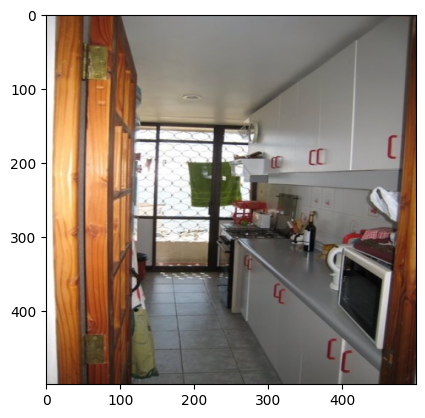

In [ ]:
modelTest.eval()
count = 0
arrayOfImagesAndAnnotations = []
cleanAnnotationsFolder = os.listdir(pathToCleanAnnotationsFolder)
for xmlfile in cleanAnnotationsFolder:
  if count < 140:
    count += 1
    continue
  count += 1
  jpgfile = xmlfile[:-3] + "jpg"

  testImage = imageAndAnnotationsCustomDataset(jpgfile)
  break

img = np.transpose(testImage.imageTensor.numpy(), (1, 2, 0))
img = img / 2 + 0.5
plt.imshow(img)
with torch.no_grad():
  predictions1 = modelTest([testImage.imageTensor.to(device)])

[3, 18, 2, 1, 22]
['door', 'stove', 'lamp', 'wall', 'worktop']


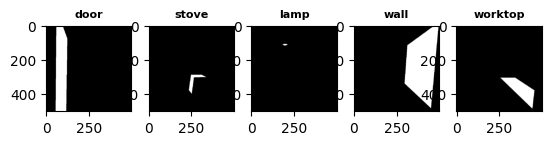

In [ ]:
labelList = testImage.objectList
decodedList = []
print(labelList)
indiceList = []
for i, item in enumerate(labelList):
  decodedList.append(listOfDesiredClasses[item])
  indiceList.append(i)
print(decodedList)
k = 0

for j in indiceList:
  img = testImage.masks[j].squeeze().cpu().numpy()
  img[img > 0] = 1
  plt.subplot(3, 5, k+1)


  plt.title(decodedList[k], color='black', fontsize=8, fontweight='bold')
  plt.imshow(img, cmap='gray')
  k += 1

[0.9591202735900879, 0.9509572386741638, 0.8646422624588013, 0.8178176879882812, 0.6833310127258301, 0.5051843523979187, 0.44966739416122437, 0.4440612196922302, 0.3782646059989929, 0.3114318251609802, 0.2712343633174896, 0.171143040060997, 0.07735775411128998, 0.0700397863984108]
[7, 3, 1, 1, 19, 12, 8, 5, 36, 6, 7, 7, 26, 6]
['shelves', 'door', 'wall', 'wall']


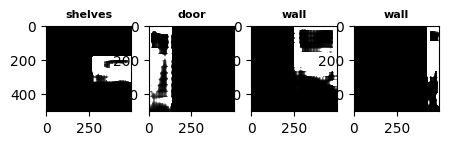

In [ ]:
labelList = predictions1[0]['labels'].tolist()
scoreList = predictions1[0]['scores'].tolist()
print(scoreList)
decodedList = []
print(labelList)
indiceList = []
for i, item in enumerate(labelList):
  if scoreList[i] >= 0.75:
    decodedList.append(listOfDesiredClasses[item])
    indiceList.append(i)
print(decodedList)
k = 0

for j in indiceList:
  img = predictions1[0]['masks'][j].squeeze().cpu().numpy()

  min_val = np.min(img)
  max_val = np.max(img)

  plt.subplot(3, 5, k+1)




  plt.title(decodedList[k], color='black', fontsize=8, fontweight='bold')
  plt.imshow(img, cmap='gray', vmin = 0, vmax = max_val/100000000)
  k += 1